# Sitem Rekomendasi

## Data Loading

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "ichsannuriman"
os.environ['KAGGLE_KEY'] = "e20dd538318e3a23d0bbfdf1e29fbdb8"

In [2]:
!kaggle datasets download -d CooperUnion/anime-recommendations-database

 68% 17.0M/25.0M [00:00<00:00, 14.9MB/s]
100% 25.0M/25.0M [00:00<00:00, 27.2MB/s]


In [3]:
!unzip -q anime-recommendations-database.zip -d .

In [4]:
import pandas as pd
import numpy as np 
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

## Data Understanding

In [5]:
anime = pd.read_csv('/content/anime.csv')
rating = pd.read_csv('/content/rating.csv')

print('Jumlah data nama anime: ', len(anime.name.unique()))
print('Jumlah data user yang memberi rating: ', len(rating.user_id.unique()))

Jumlah data nama anime:  12292
Jumlah data user yang memberi rating:  73515


## Univariate Analysis and Data Preparation

### Informasi Dataframe anime.csv

In [6]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [7]:
print('Banyak anime: ', len(anime.name.unique()))
print('Genre anime: ', anime.genre.unique())

Banyak anime:  12292
Genre anime:  ['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen' ...
 'Hentai, Sports' 'Drama, Romance, School, Yuri' 'Hentai, Slice of Life']


In [8]:
anime

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


#### Mengatasi Missing Value

In [9]:
anime.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [10]:
anime =  anime.dropna()
anime.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

### Informasi Dataframe rating.csv

In [11]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [12]:
#Hanya mengambil 2000 jumlah data
rating = rating.drop(range(2000, 7813737))
rating

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
1995,17,20931,5
1996,17,20939,-1
1997,17,20965,6
1998,17,20973,6


In [13]:
rating["rating"].replace({-1: np.nan}, inplace=True)
rating.head()

,user_id,anime_id,rating
0,1,20,NaN
1,1,24,NaN
2,1,79,NaN
3,1,226,NaN
4,1,241,NaN


In [14]:
rating = rating.dropna(axis = 0, how ='any')
rating

,user_id,anime_id,rating
47,1,8074,10.0
81,1,11617,10.0
83,1,11757,10.0
101,1,15451,10.0
153,2,11771,10.0
...,...,...,...
1993,17,20899,9.0
1994,17,20903,6.0
1995,17,20931,5.0
1997,17,20965,6.0


In [15]:
rating.describe()

,user_id,anime_id,rating
count,1452.000000,1452.000000,1452.000000
mean,9.017218,11399.560606,6.409091
std,4.837865,9031.895302,2.240686
min,1.000000,6.000000,1.000000
25%,5.000000,2602.250000,5.000000
50%,7.000000,10412.500000,7.000000
75%,14.000000,18191.500000,8.000000
max,17.000000,33341.000000,10.000000


In [16]:
print('Jumlah user_id: ', len(rating.user_id.unique()))
print('Jumlah anime_id: ', len(rating.anime_id.unique()))
print('Jumlah data rating: ', len(rating))

Jumlah user_id:  14
Jumlah anime_id:  966
Jumlah data rating:  1452


## Content Based Filtering

### TF-IDF Vectorizer

In [17]:
tf = TfidfVectorizer()

tf.fit(anime['genre']) 

tf.get_feature_names() 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['action',
 'adventure',
 'ai',
 'arts',
 'cars',
 'comedy',
 'dementia',
 'demons',
 'drama',
 'ecchi',
 'fantasy',
 'fi',
 'game',
 'harem',
 'hentai',
 'historical',
 'horror',
 'josei',
 'kids',
 'life',
 'magic',
 'martial',
 'mecha',
 'military',
 'music',
 'mystery',
 'of',
 'parody',
 'police',
 'power',
 'psychological',
 'romance',
 'samurai',
 'school',
 'sci',
 'seinen',
 'shoujo',
 'shounen',
 'slice',
 'space',
 'sports',
 'super',
 'supernatural',
 'thriller',
 'vampire',
 'yaoi',
 'yuri']

In [18]:
tfidf_matrix = tf.fit_transform(anime['genre']) 

tfidf_matrix.shape 

(12017, 47)

In [19]:
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.29498527, 0.3162867 , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.2516182 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [20]:
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names(),
    index=anime.name
).sample(22, axis=1).sample(10, axis=0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,harem,game,mecha,supernatural,super,space,romance,kids,yuri,hentai,demons,action,vampire,comedy,historical,fi,slice,music,magic,dementia,ai,ecchi
name,,,,,,,,,,,,,,,,,,,,,,
Hennako-chan,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
Fune wo Amu,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.518324,0.0,0.000000,0.0,0.0,0.0
Yotsunoha,0.000000,0.0,0.0,0.0,0.0,0.0,0.684808,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
Utawarerumono Specials,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.493651,0.0,0.393170,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
D.C. I&amp;II P.S.P. Re-Animated,0.635281,0.0,0.0,0.0,0.0,0.0,0.427164,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.516560,0.0,0.0,0.0
Mai Zhu,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.468081,0.883686,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
Crystal Blaze,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.532356,0.0,0.000000,0.000000,0.598581,0.000000,0.0,0.000000,0.0,0.0,0.0
Shou-chan Sora wo Tobu,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.464764,0.000000,0.0,0.000000,0.0,0.0,0.0
Densetsu no Yuusha no Densetsu,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.375870,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.575209,0.0,0.0,0.0


### Cosine Similarity

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1.        , 0.14715318, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14715318, 1.        , 0.17877808, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.17877808, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [22]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=anime['name'], columns=anime['name'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (12017, 12017)


name,Daraku: Onna Kyoushi Hakai,Gosick,Kakutou Bijin Wulong: Rebirth,Parasol Henbei,Monster ni Natta Domerica
name,,,,,
Digimon Adventure 3D: Digimon Grand Prix!,0.0,0.000000,0.137067,0.506145,0.437036
0-sen Hayato Pilot,0.0,0.343203,0.000000,0.000000,0.000000
Sore Ike! Anpanman: Outa to Teasobi Tanoshii ne,0.0,0.000000,0.098791,0.697434,0.438948
Arcade Gamer Fubuki,0.0,0.000000,0.205609,0.058043,0.161662
Heisa Byouin,1.0,0.000000,0.000000,0.000000,0.000000
Kyoto Animation: Ikitaku Naru Omise-hen,0.0,0.000000,0.000000,0.000000,0.000000
Pororo Daemoheom,0.0,0.000000,0.000000,0.623645,0.000000
Lupin III: Honoo no Kioku - Tokyo Crisis,0.0,0.384297,0.323430,0.256779,0.254299
Aiura,0.0,0.000000,0.359687,0.080121,0.000000


### Fungsi Rekomendasi

In [23]:
import tensorflow as tf

def anime_recommendations(nama_anime, similarity_data=cosine_sim_df, items=anime[['name', 'genre']], k=5):
    
    index = similarity_data.loc[:,nama_anime].to_numpy().argpartition(
        range(-1, -k, -1))
    
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    closest = closest.drop(nama_anime, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

### Uji Coba

In [24]:
anime[anime.name.eq('Kimi no Na wa.')]

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630


In [25]:
result = anime_recommendations('Kimi no Na wa.')
result

,name,genre
0,Wind: A Breath of Heart OVA,"Drama, Romance, School, Supernatural"
1,Wind: A Breath of Heart (TV),"Drama, Romance, School, Supernatural"
2,Aura: Maryuuin Kouga Saigo no Tatakai,"Comedy, Drama, Romance, School, Supernatural"
3,Angel Beats!: Another Epilogue,"Drama, School, Supernatural"
4,Harmonie,"Drama, School, Supernatural"


In [26]:
a = 0

for row in result.itertuples():
  if (row.genre == 'Drama, Romance, School, Supernatural'):
    a += 1

precision = (a/5)*100
print("The precision of the model is {}%".format(precision))

The precision of the model is 40.0%


In [27]:
anime_recommendations('Steins;Gate')

,name,genre
0,Steins;Gate: Kyoukaimenjou no Missing Link - D...,"Sci-Fi, Thriller"
1,Steins;Gate Movie: Fuka Ryouiki no Déjà vu,"Sci-Fi, Thriller"
2,Steins;Gate: Oukoubakko no Poriomania,"Sci-Fi, Thriller"
3,Ibara no Ou,"Action, Mystery, Sci-Fi, Thriller"
4,Loups=Garous,"Mystery, Sci-Fi, Thriller"


## Collaborative Based Filtering

### Menyiapkan Tabel Rating

In [28]:
df = rating
df

,user_id,anime_id,rating
47,1,8074,10.0
81,1,11617,10.0
83,1,11757,10.0
101,1,15451,10.0
153,2,11771,10.0
...,...,...,...
1993,17,20899,9.0
1994,17,20903,6.0
1995,17,20931,5.0
1997,17,20965,6.0


#### Encoding

In [29]:
user_ids = df['user_id'].unique().tolist()
print('list user_id: ', user_ids)

user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded user_id : ', user_to_user_encoded)

user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke user_id: ', user_encoded_to_user)

list user_id:  [1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17]
encoded user_id :  {1: 0, 2: 1, 3: 2, 5: 3, 7: 4, 8: 5, 9: 6, 10: 7, 11: 8, 12: 9, 14: 10, 15: 11, 16: 12, 17: 13}
encoded angka ke user_id:  {0: 1, 1: 2, 2: 3, 3: 5, 4: 7, 5: 8, 6: 9, 7: 10, 8: 11, 9: 12, 10: 14, 11: 15, 12: 16, 13: 17}


In [30]:
anime_ids = df['anime_id'].unique().tolist()

anime_to_anime_encoded = {x: i for i, x in enumerate(anime_ids)}

anime_encoded_to_anime = {i: x for i, x in enumerate(anime_ids)}

#### Memetakan user_id dan anime_id

In [31]:
df['user'] = df['user_id'].map(user_to_user_encoded)

df['anime'] = df['anime_id'].map(anime_to_anime_encoded)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Mengecek jumlah user, jumlah resto, rating terkecil, dan rating terbesar

In [32]:
num_users = len(user_to_user_encoded)
print(num_users)

num_anime = len(anime_encoded_to_anime)
print(num_anime)

min_rating = min(df['rating'])

max_rating = max(df['rating'])
 
print('Number of User: {}, Number of Anime: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_anime, min_rating, max_rating
))

14
966
Number of User: 14, Number of Anime: 966, Min Rating: 1.0, Max Rating: 10.0


#### Mengacak Data

In [33]:
df = df.sample(frac=1, random_state=42)
df

,user_id,anime_id,rating,user,anime
1293,12,2904,10.0,9,549
1555,14,11887,8.0,10,831
1254,11,6707,4.0,8,774
1796,17,10396,5.0,13,310
739,5,25157,1.0,3,490
...,...,...,...,...,...
1526,14,8676,7.0,10,819
1561,14,14345,7.0,10,53
1759,17,8100,7.0,13,904
1110,7,30365,7.0,4,677


### Train-Test Split

In [34]:
x = df[['user', 'anime']].values

y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
 
print(x, y)

[[  9 549]
 [ 10 831]
 [  8 774]
 ...
 [ 13 904]
 [  4 677]
 [ 10 350]] [1.         0.77777778 0.33333333 ... 0.66666667 0.66666667 0.66666667]


### Fungsi Rekomendasi

In [35]:
class RecommenderNet(tf.keras.Model):

  def __init__(self, num_users, num_anime, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_anime = num_anime
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.anime_embedding = layers.Embedding(
        num_anime,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.anime_bias = layers.Embedding(num_anime, 1)
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    anime_vector = self.anime_embedding(inputs[:, 1])
    anime_bias = self.anime_bias(inputs[:, 1])
 
    dot_user_anime = tf.tensordot(user_vector, anime_vector, 2) 
 
    x = dot_user_anime + user_bias + anime_bias
    
    return tf.nn.sigmoid(x)

### Compile Model

In [36]:
model = RecommenderNet(num_users, num_anime, 50)
 
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

### Training Model

In [37]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
146/146 [==============================] - 4s 8ms/step - loss: 0.6942 - root_mean_squared_error: 0.2680 - val_loss: 0.6847 - val_root_mean_squared_error: 0.2661
Epoch 2/100
146/146 [==============================] - 1s 6ms/step - loss: 0.6743 - root_mean_squared_error: 0.2483 - val_loss: 0.6806 - val_root_mean_squared_error: 0.2622
Epoch 3/100
146/146 [==============================] - 1s 6ms/step - loss: 0.6588 - root_mean_squared_error: 0.2332 - val_loss: 0.6743 - val_root_mean_squared_error: 0.2561
Epoch 4/100
146/146 [==============================] - 1s 6ms/step - loss: 0.6541 - root_mean_squared_error: 0.2279 - val_loss: 0.6713 - val_root_mean_squared_error: 0.2531
Epoch 5/100
146/146 [==============================] - 1s 6ms/step - loss: 0.6411 - root_mean_squared_error: 0.2146 - val_loss: 0.6654 - val_root_mean_squared_error: 0.2473
Epoch 6/100
146/146 [==============================] - 1s 6ms/step - loss: 0.6374 - root_mean_squared_error: 0.2097 - val_loss: 0.6636 

### Visualisasi Metrik

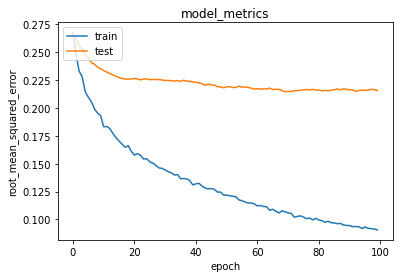

In [38]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Mendapatkan Rekomendasi Resto

In [39]:
anime_df = anime
df = rating

userID = df.user_id.sample(1).iloc[0]
anime_watched_by_user = df[df.user_id == userID]
 
anime_not_watched = anime_df[~anime_df['anime_id'].isin(anime_watched_by_user.anime_id.values)]['anime_id'] 
anime_not_watched = list(
    set(anime_not_watched)
    .intersection(set(anime_to_anime_encoded.keys()))
)
 
anime_not_watched = [[anime_to_anime_encoded.get(x)] for x in anime_not_watched]
user_encoder = user_to_user_encoded.get(userID)
user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)

In [40]:
from tensorflow import keras

ratings = model.predict(user_anime_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_anime_ids = [
    anime_encoded_to_anime.get(anime_not_watched[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(userID))
print('===' * 9)
print('Anime with high ratings from user')
print('----' * 8)
 
top_anime_user = (
    anime_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .anime_id.values
)
 
anime_df_rows = anime_df[anime_df['anime_id'].isin(top_anime_user)]
for row in anime_df_rows.itertuples():
    print(row.name, ':', row.genre)
 
print('----' * 8)
print('Top 10 anime recommendation')
print('----' * 8)
 
recommended_anime = anime_df[anime_df['anime_id'].isin(recommended_anime_ids)]
for row in recommended_anime.itertuples():
    print(row.name, ':', row.genre)

Showing recommendations for users: 5
Anime with high ratings from user
--------------------------------
Gintama&#039; : Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen
Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare : Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen
Haikyuu!! Second Season : Comedy, Drama, School, Shounen, Sports
Great Teacher Onizuka : Comedy, Drama, School, Shounen, Slice of Life
Stranger: Mukou Hadan : Action, Adventure, Historical, Samurai
--------------------------------
Top 10 anime recommendation
--------------------------------
Clannad: After Story : Drama, Fantasy, Romance, Slice of Life, Supernatural
Ookami Kodomo no Ame to Yuki : Fantasy, Slice of Life
Shingeki no Kyojin : Action, Drama, Fantasy, Shounen, Super Power
Sakamichi no Apollon : Drama, Josei, Music, Romance, School
Kuroko no Basket : Comedy, School, Shounen, Sports
Neon Genesis Evangelion: The End of Evangelion : Dementia, Drama, Mecha, Psychological, Sci-Fi
Shoujo Kak